In [1]:
import os

import glob
import time
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter, binary_fill_holes
from skimage import morphology
from skimage.measure import label, regionprops

from skimage.segmentation import (
    morphological_chan_vese,
    checkerboard_level_set,
)

In [3]:
def load_images(files, resize=(256,256)):
    images = []
    for file in files:
        im = Image.open(file)
        im = ImageOps.exif_transpose(im)
        if resize:
            im = im.resize(resize)
        im = im.convert('L')
        images.append(np.array(im))
    return np.array(images)

In [4]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

In [5]:
def keep_largest_connected_component(segmented_mask):
    """
    Keep only the largest connected component in a segmented binary mask.

    Parameters:
        segmented_mask (ndarray): Binary mask from segmentation (0s and 1s).
    
    Returns:
        ndarray: Binary mask with only the largest connected component.
    """
    labeled_mask = label(segmented_mask)
    
    largest_component = max(regionprops(labeled_mask), key=lambda r: r.area)
    
    largest_mask = (labeled_mask == largest_component.label).astype(np.uint8)
    return largest_mask

In [8]:
BASE_OUTPUT_PATH = 'outputs/segmentation_snakes'

In [9]:
mode = ['images', 'masks']
BASE_PATH_IMGS = os.path.join('data', mode[0])
BASE_PATH_MASKS = os.path.join('data', mode[1])
files = glob.glob(os.path.join(BASE_PATH_IMGS, '*'))
files_masks = glob.glob(os.path.join(BASE_PATH_MASKS, '*'))

In [11]:
images = load_images(files)
masks = load_images(files_masks)

In [21]:
image = images[0]
init_ls = checkerboard_level_set(image.shape, 16)

evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 50, init_level_set=init_ls, smoothing=3, iter_callback=callback)

In [7]:
%matplotlib inline
from IPython.display import display, clear_output

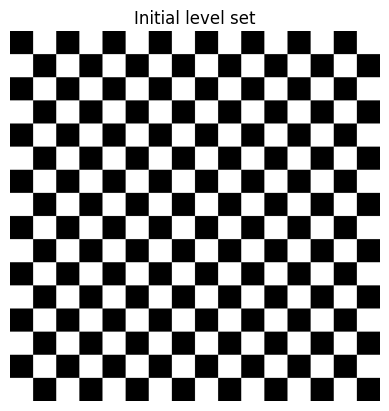

In [22]:
plt.imshow(init_ls, cmap="gray")
plt.axis("off")
plt.title("Initial level set")
plt.savefig(os.path.join(BASE_OUTPUT_PATH, 'initial_level_set.png'))
plt.show()

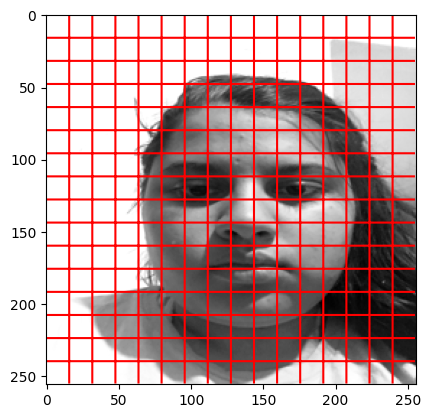

In [9]:
plt.imshow(image, cmap="gray")
plt.contour(evolution[0], [0.5], colors='r')
plt.show()

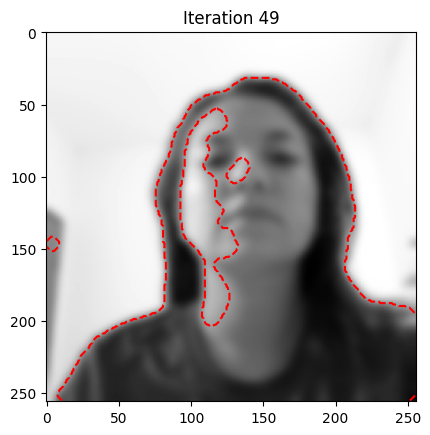

In [42]:
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')

for i in range(len(evolution)):
    ax.contour(evolution[i], [0.5], colors='r', linestyles='dashed')
    clear_output(wait=True)
    display(fig)
    ax.set_title(f"Iteration {i}")
    plt.pause(0.1)
    for collection in ax.collections:
        collection.remove()

plt.show()

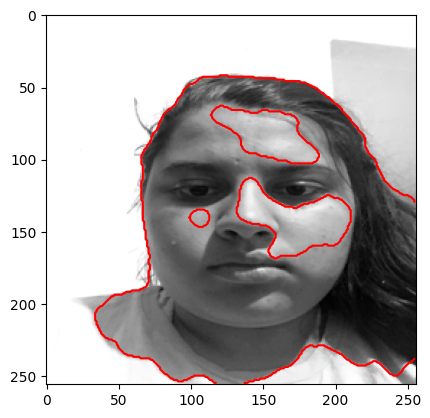

In [11]:
plt.imshow(image, cmap='gray')
plt.contour(evolution[-1], [0.5], colors='r')
plt.show()

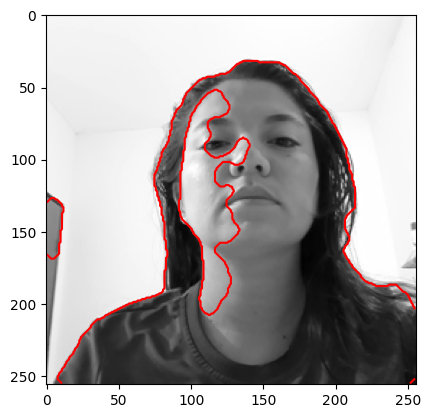

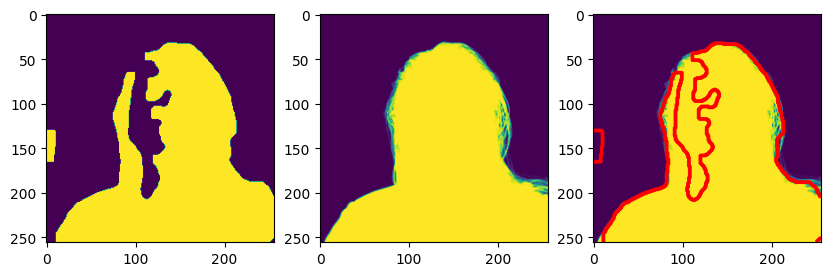

In [12]:
idx = 1
image = images[idx]

init_ls = checkerboard_level_set(image.shape, 6)

evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 100, init_level_set=init_ls, smoothing=3, iter_callback=callback)

plt.imshow(image, cmap='gray')
plt.contour(evolution[-1], [0.5], colors='r')
plt.show()

mask = np.zeros_like(image)
mask[evolution[-1] > 0.5] = 1
footprint = morphology.square(9)
for i in range(7):
    mask = morphology.erosion(mask, footprint)
    mask = morphology.dilation(mask, footprint)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(mask)
plt.subplot(1, 3, 2)
plt.imshow(masks[idx])

plt.subplot(1, 3, 3)
mask_line = mask - morphology.erosion(mask, morphology.square(3))
plt.imshow(masks[idx])
plt.contour(mask_line, alpha=0.5, colors=['r'])

plt.show()

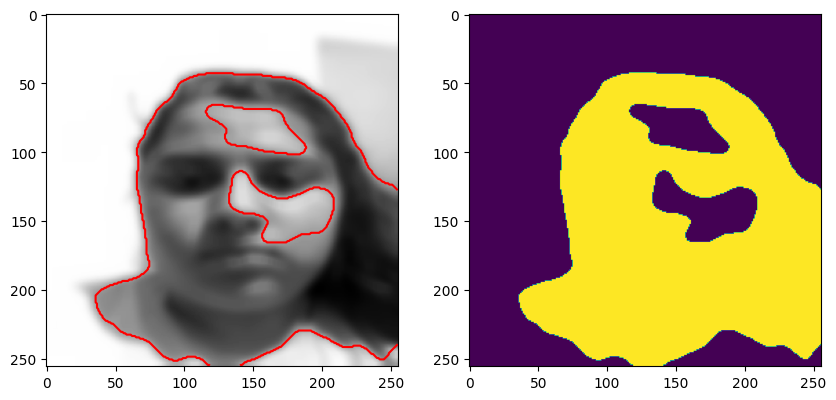

In [13]:

def preprocess_images(image):
    low_pass_filter = gaussian_filter(image, sigma=3)
    return low_pass_filter

image = images[0]
low_pass_filter = preprocess_images(image)

image = low_pass_filter

footprint = morphology.square(5)
image = morphology.erosion(image, footprint)
image = morphology.dilation(image, footprint)

init_ls = checkerboard_level_set(image.shape, 6)

evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 100, init_level_set=init_ls, smoothing=3, iter_callback=callback)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.contour(evolution[-1], [0.5], colors='r')

mask = np.zeros_like(image)
mask[evolution[-1] > 0.5] = 1

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [14]:
# Verify the binary images and check if the borders marked as 0 or 1, if not, correct it
def verify_binary_image(binary_image):
    if np.median(binary_image[0, :]) == 1:
        binary_image = 1 - binary_image
    return binary_image

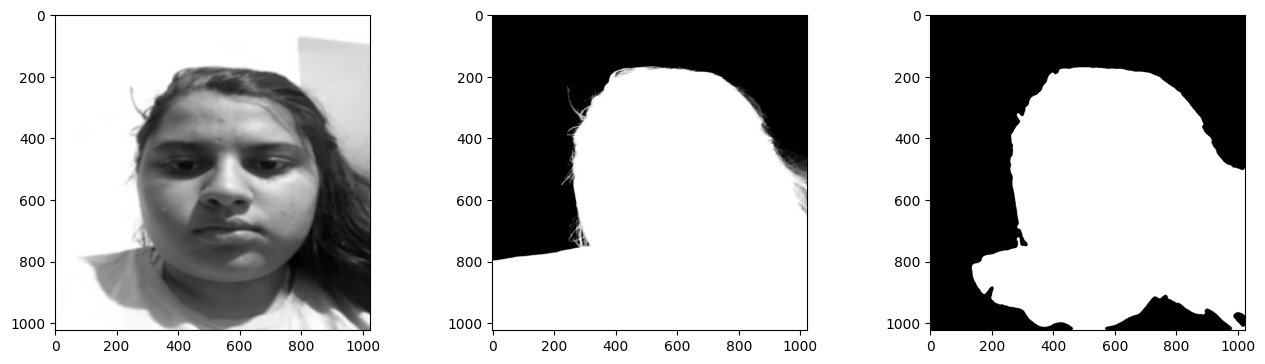

In [21]:
i = 0
name = files[i].split('/')[-1][:-4]
image = images[i]
image = gaussian_filter(image, sigma=3)

init_ls = checkerboard_level_set(image.shape, 16)

evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 50, init_level_set=init_ls, smoothing=3, iter_callback=callback)

mask = np.zeros_like(image)
mask[evolution[-1] > 0.5] = 1
mask = verify_binary_image(mask)
mask = binary_fill_holes(mask).astype('uint8')

# Save mask
# mask = Image.fromarray(mask * 255)
# mask.save(os.path.join(BASE_OUTPUT_PATH, f'{name}.png'))

plt.figure(figsize=(16, 9))
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')

plt.subplot(2, 3, 2)
plt.imshow(masks[i], cmap='gray')

plt.subplot(2,3,3)
plt.imshow(mask, cmap='gray')

plt.show()

In [31]:
def run_exp(resize, debug=False):
    images = load_images(files, resize=resize)
    masks = load_images(files_masks, resize=resize)

    t1 = time.time()
    for i in range(len(images)):
        name = files[i].split('/')[-1][:-4]
        image = images[i]
        image = gaussian_filter(image, sigma=3)

        init_ls = checkerboard_level_set(image.shape, 16)

        evolution = []
        callback = store_evolution_in(evolution)
        ls = morphological_chan_vese(image, 100, init_level_set=init_ls, smoothing=3, iter_callback=callback)

        mask = np.zeros_like(image)
        mask[evolution[-1] > 0.5] = 1
        mask = verify_binary_image(mask)
        mask = morphology.remove_small_objects(mask.astype('bool'), min_size=64, connectivity=1)
        mask = binary_fill_holes(mask).astype('uint8')
        mask = keep_largest_connected_component(mask)

        # Save mask
        mask = Image.fromarray(mask * 255)
        out_full_path = os.path.join(BASE_OUTPUT_PATH, f'{resize[0]}x{resize[1]}')
        if not os.path.exists(out_full_path):
            os.makedirs(out_full_path)
        mask.save(os.path.join(out_full_path, f'{name}.png'))

        if debug:
                plt.figure(figsize=(16, 9))
                plt.subplot(2, 3, 1)
                plt.imshow(image)
                
                plt.subplot(2, 3, 2)
                plt.imshow(masks[i])
                
                plt.subplot(2,3,3)
                plt.imshow(mask)

                plt.show()
    t2 = time.time()

    print(f"Took {t2 - t1} seconds to process {len(images)} images.")

In [32]:
run_exp((256, 256))

Took 19.180415391921997 seconds to process 19 images.


In [33]:
run_exp((64, 64))

Took 2.4124748706817627 seconds to process 19 images.


In [34]:
run_exp((1024, 1024))

Took 301.17503571510315 seconds to process 19 images.
